## Clustering using DBSCAN

In [ ]:
import numpy as np
import netCDF4
from sklearn.cluster import DBSCAN

file_path = '/home/ocean_personal_data/albinski/croco_grd.nc'  
with netCDF4.Dataset(file_path, 'r') as f:  # r is for read only
    mask_psi = f.variables['mask_psi'][:]
    lon_psi = f.variables['lon_psi'][:]
    lat_psi = f.variables['lat_psi'][:]

mask_zero_indices = np.where(mask_psi == 0)

lon_psi_mask_zero = lon_psi[mask_zero_indices]
lat_psi_mask_zero = lat_psi[mask_zero_indices]

X = np.column_stack((lon_psi_mask_zero, lat_psi_mask_zero))  # makes the 1Ds into a single 2D

# defining the epsilon for DBSCAN
epsilon = 2/50  # Adjust this value as needed

# performing DBSCAN clustering with the distance threshold
clustering_model = DBSCAN(eps=epsilon, min_samples=1)  # min no. of data points that should be present in neighbourhood to be a core point
clustering_labels_psi = clustering_model.fit_predict(X)

np.save('clustering_labels_psi.npy', clustering_labels_psi)  # store the data in like a permanent numpy array

print(f"Clustering completed. Number of clusters formed: {len(np.unique(clustering_labels_psi))}")


## Visualisng one specific island ID

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  58  59  60 100 105 140 150 200 220 269 300 330 350]


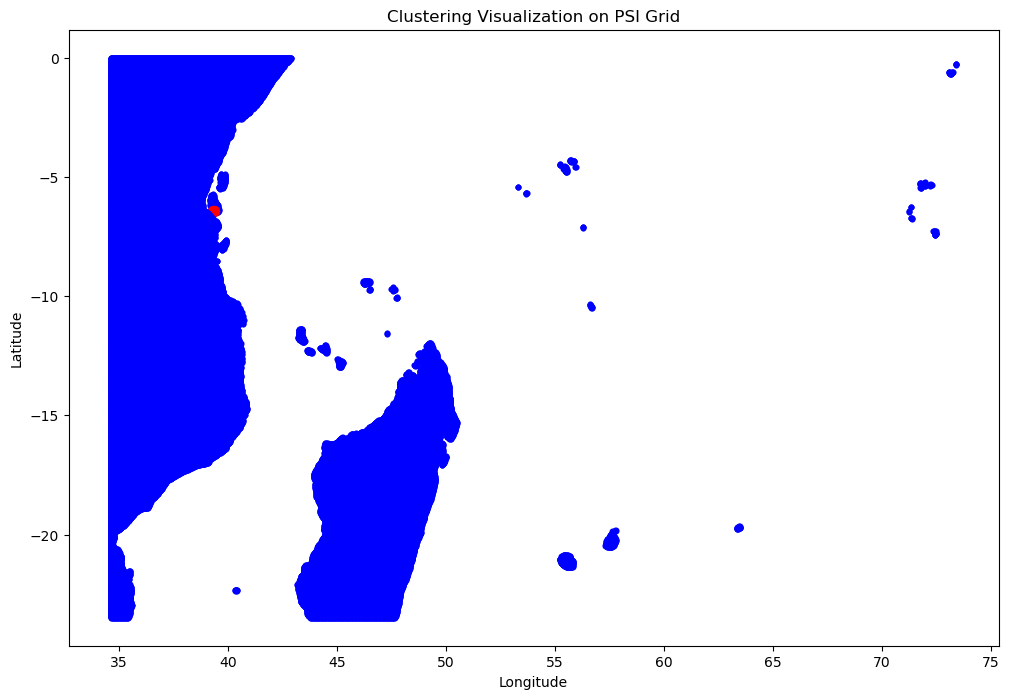

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4

file_path = '/home/ocean_personal_data/albinski/croco_grd.nc' 
with netCDF4.Dataset(file_path, 'r') as f:
    mask_psi = f.variables['mask_psi'][:]
    lon_psi = f.variables['lon_psi'][:]
    lat_psi = f.variables['lat_psi'][:]

clustering_labels_psi = np.load('/home/ocean_personal_data/albinski/updated_clustering_labels_psi.npy') 

mask_zero_indices = np.where(mask_psi == 0)
lon_psi_mask_zero = lon_psi[mask_zero_indices]
lat_psi_mask_zero = lat_psi[mask_zero_indices]

plt.figure(figsize=(12, 8))
unique_labels = np.unique(clustering_labels_psi)
print(unique_labels)
for label in unique_labels:

    if label == 44:
        cluster_points = (clustering_labels_psi == label)
        plt.scatter(lon_psi_mask_zero[cluster_points], lat_psi_mask_zero[cluster_points], s=50, label=f'Cluster {label}', color = 'red')

    else:
        cluster_points = (clustering_labels_psi == label)
        plt.scatter(lon_psi_mask_zero[cluster_points], lat_psi_mask_zero[cluster_points], s=10, label=f'Cluster {label}', color = 'blue')


plt.title('Clustering Visualization on PSI Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


plt.show()


## Recategorising some IDs

In [ ]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
file_path = '/home/ocean_personal_data/albinski/croco_grd.nc'
with netCDF4.Dataset(file_path, 'r') as f:
    mask_psi = f.variables['mask_psi'][:]
    lon_psi = f.variables['lon_psi'][:]
    lat_psi = f.variables['lat_psi'][:]

clustering_labels = np.load('/home/ocean_personal_data/albinski/clustering_labels_psi.npy')

labels_grid = np.full(mask_psi.shape, -1)
labels_grid[np.where(mask_psi == 0)] = clustering_labels

# First split (Kenya and Tanzania)
border_point_kenya_tanzania = np.array([-4.679617, 39.218382])
east_african_coast = (labels_grid == 0)
lat_east_africa = lat_psi[east_african_coast]
lon_east_africa = lon_psi[east_african_coast]
distances = np.sqrt((lat_east_africa - border_point_kenya_tanzania[0])**2 + (lon_east_africa - border_point_kenya_tanzania[1])**2)
closest_point_idx = np.argmin(distances)
closest_point_lat = lat_east_africa[closest_point_idx]
greater_than_closest_lat = (labels_grid == 0) & (lat_psi > closest_point_lat)
labels_grid[greater_than_closest_lat] = 100  # Assigning Kenya

# Second split (Tanzania and Mozambique)
border_point_tanzania_mozambique = np.array([-10.471067, 40.436925])
east_african_coast = (labels_grid == 0)
lat_east_africa = lat_psi[east_african_coast]
lon_east_africa = lon_psi[east_african_coast]
distances = np.sqrt((lat_east_africa - border_point_tanzania_mozambique[0])**2 + (lon_east_africa - border_point_tanzania_mozambique[1])**2)
closest_point_idx = np.argmin(distances)
closest_point_lat = lat_east_africa[closest_point_idx]
less_than_closest_lat = (labels_grid == 0) & (lat_psi <= closest_point_lat)
labels_grid[less_than_closest_lat] = 140  # Assigning Mozambique

# Assign the remaining label 0 points to 105 (Tanzania)
labels_grid[labels_grid == 0] = 105  # Assigning Tanzania
# Identify Aldabra Atoll (ID 32)
aldabra_atoll = (labels_grid == 32)

# Extract coordinates of Aldabra Atoll
lat_aldabra = lat_psi[aldabra_atoll]
lon_aldabra = lon_psi[aldabra_atoll]

central_lat = np.mean(lat_aldabra)
central_lon = np.mean(lon_aldabra)

# Split Aldabra Atoll into East and West regions
east_aldabra = (lon_psi >= central_lon) & aldabra_atoll
west_aldabra = (lon_psi < central_lon) & aldabra_atoll

north_east_aldabra = (lat_psi >= central_lat) & east_aldabra
south_east_aldabra = (lat_psi < central_lat) & east_aldabra
north_west_aldabra = (lat_psi >= central_lat) & west_aldabra
south_west_aldabra = (lat_psi < central_lat) & west_aldabra

labels_grid[north_east_aldabra] = 150  # North East region
labels_grid[south_east_aldabra] = 200  # South East region
labels_grid[north_west_aldabra] = 220  # North West region
labels_grid[south_west_aldabra] = 269  # South West region

mahe_island = (labels_grid == 54)

lat_mahe = lat_psi[mahe_island]
lon_mahe = lon_psi[mahe_island]

central_lat_mahe = np.mean(lat_mahe)

# Split Mahe Island into North and South regions
north_mahe = (lat_psi >= central_lat_mahe) & mahe_island
south_mahe = (lat_psi < central_lat_mahe) & mahe_island


labels_grid[north_mahe] = 330 
labels_grid[south_mahe] = 350 

labels_grid[labels_grid == 1] = 300

distances, indices = distance_transform_edt(mask_psi != 0, return_indices=True)
nearest_land_indices = tuple(indices[i, mask_psi != 0] for i in range(len(indices)))

ocean_labels = labels_grid[nearest_land_indices]
final_labels_grid_psi = np.full(mask_psi.shape, -1)
final_labels_grid_psi[mask_psi != 0] = ocean_labels

final_labels_grid_masked_psi = np.ma.masked_where(final_labels_grid_psi == -1, final_labels_grid_psi)

unique_labels = np.unique(final_labels_grid_masked_psi)
print(unique_labels)
unique_labels = unique_labels[unique_labels != -1]
colors = np.random.rand(len(unique_labels), 3)
random_cmap = ListedColormap(colors)

f, ax = plt.subplots(1, 1, figsize=(112, 20))
plt.pcolormesh(lon_psi, lat_psi, final_labels_grid_masked_psi, cmap=random_cmap)
plt.colorbar(label='Cluster Labels')
plt.title('Visualization of Updated Clustering Labels')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
ax.set_aspect('equal')
plt.show()

updated_clustering_labels = labels_grid[mask_psi == 0]

np.save('/home/ocean_personal_data/albinski/updated_clustering_labels_psi.npy', updated_clustering_labels)

print("Updated clustering labels saved successfully.")


## Trying to make a mask that defines the grid in terms of compass slices away from a given island

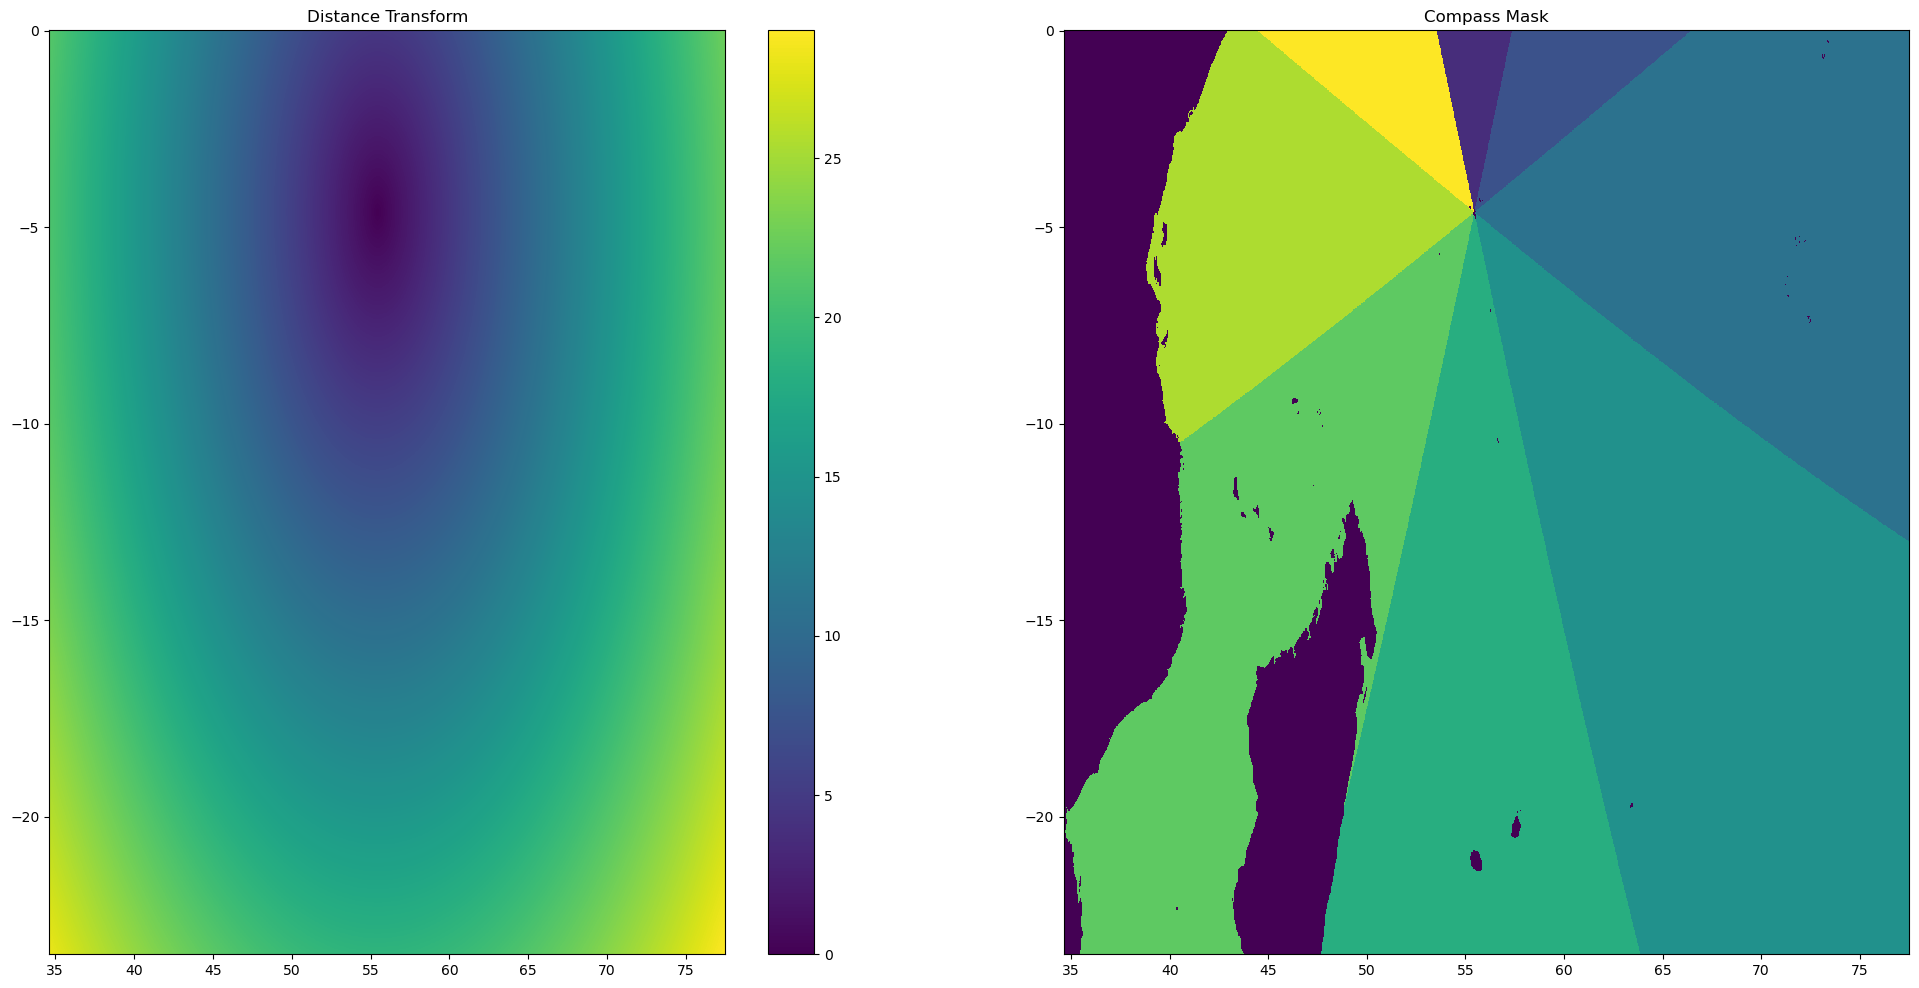

In [1]:
import numpy as np
import netCDF4
import math
import matplotlib.pyplot as plt

file_path = '/home/ocean_personal_data/albinski/croco_grd.nc'
clustering_labels_path = '/home/ocean_personal_data/albinski/updated_clustering_labels_psi.npy'

with netCDF4.Dataset(file_path, 'r') as f:
    mask_psi = f.variables['mask_psi'][:]
    lon_psi = f.variables['lon_psi'][:]
    lat_psi = f.variables['lat_psi'][:]

clustering_labels_psi = np.load(clustering_labels_path)

mask_zero_indices = np.where(mask_psi == 0)
lon_psi_mask_zero = lon_psi[mask_zero_indices]
lat_psi_mask_zero = lat_psi[mask_zero_indices]

cluster_points = clustering_labels_psi == 150

land_lon = lon_psi_mask_zero[cluster_points]
land_lat = lat_psi_mask_zero[cluster_points]
mean_lon = np.mean(land_lon)
mean_lat = np.mean(land_lat)

distances = np.sqrt((land_lat - mean_lat)**2 + (land_lon - mean_lon)**2)
central_point_idx = np.argmin(distances)
central_lon, central_lat = land_lon[central_point_idx], land_lat[central_point_idx]

distance_transform = np.sqrt((lat_psi - central_lat)**2 + (lon_psi - central_lon)**2)

compass_mask = np.empty_like(lon_psi, dtype=object)

for i in range(lon_psi.shape[0]):
    for j in range(lon_psi.shape[1]):
        if mask_psi[i, j] == 1:
            lat1, lon1, lat2, lon2 = map(math.radians, [central_lat, central_lon, lat_psi[i, j], lon_psi[i, j]])
            d_lon = lon2 - lon1
            x = math.sin(d_lon) * math.cos(lat2)
            y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(d_lon))
            initial_bearing = math.atan2(x, y)
            bearing = (math.degrees(initial_bearing) + 360) % 360
            directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "N"]
            compass_direction = directions[round(bearing / 45)]
            compass_mask[i, j] = compass_direction

directions_mapping = {"N": 1, "NE": 2, "E": 3, "SE": 4, "S": 5, "SW": 6, "W": 7, "NW": 8, None: 0}

compass_mask_numeric = np.vectorize(directions_mapping.get)(compass_mask)

f, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].pcolormesh(lon_psi, lat_psi, distance_transform)
ax[0].set_title('Distance Transform')
ax[1].pcolormesh(lon_psi, lat_psi, compass_mask_numeric)
ax[1].set_title('Compass Mask')
distance_plot = ax[0].pcolormesh(lon_psi, lat_psi, distance_transform)
plt.colorbar(distance_plot, ax=ax[0], orientation='vertical')
plt.show()


0.00011198736134095698


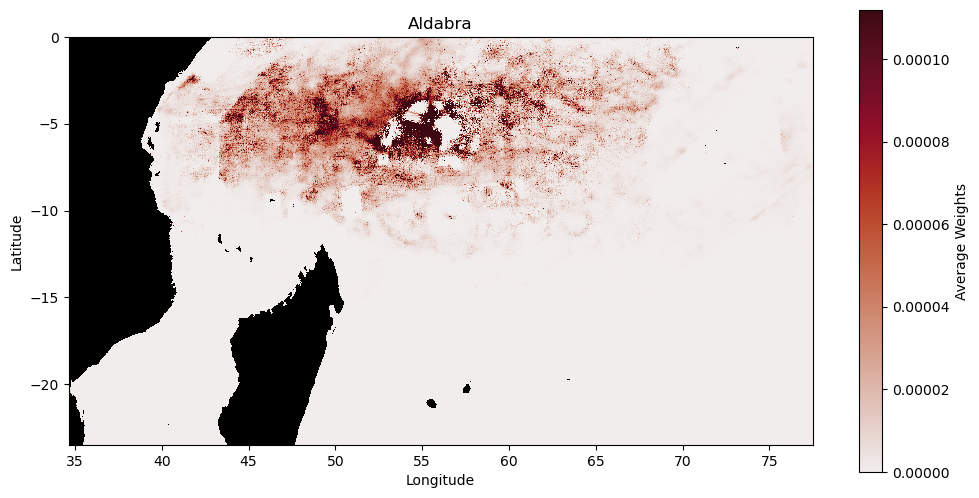

In [6]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import cmocean
from tqdm import tqdm

aldabra = [27,28,29,30,31,150,200,220,269]
chagos = [36,38,39,41,43,45,48,50,51,52,53]
amirante = [46,49]
inner = [55,56,57,330,350]
maldives = [58,59,60]

group_ids = [55,56,57,330,350]
group = []
shipping = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/ship_data_CROCO/ship_data_all_croco/avg18_22_all_months.npy')
shipping = np.nan_to_num(shipping)
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

for i in group_ids:
    array = np.load(f'/home/ocean_personal_data/albinski/AVG_RUNS_Smoothed/avg_{i}.npy')
    group.append(array)

average_array = np.mean(np.stack(group), axis=0)

array_new = average_array * shipping.T
mask = average_array == 0
array_new[mask] = 0
percentile_95 = np.nanpercentile(array_new, 99)
print(percentile_95)

f, ax = plt.subplots(1, 1, figsize=(12, 6))
cmap2 = ax.pcolormesh(grid.lon_psi[0, :], 
                     grid.lat_psi[:, 0], 
                     array_new, 
                     cmap=cmocean.cm.amp, vmin = 0, vmax = percentile_95)

plt.colorbar(cmap2, ax=ax, label='Average Weights')

ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]),
                                 mask=grid.mask_rho[1:-1, 1:-1]),
                                 cmap=cmr.neutral)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Aldabra')
plt.show()

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import xarray as xr
import imageio
import os
from PIL import Image
from io import BytesIO
import plotly.io as pio

aldabra = [27, 28, 29, 30, 31, 150, 200, 220, 269]
chagos = [36, 38, 39, 41, 43, 45, 48, 50, 51, 52, 53]
amirante = [46, 49]
inner = [55, 56, 57, 330, 350]
maldives = [58, 59, 60]

group_ids = [55, 56, 57, 330, 350]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
shipping = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/ship_data_CROCO/ship_data_all_croco/avg18_22_all_months.npy')
shipping = np.nan_to_num(shipping)
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

image_directory = '/home/ocean_personal_data/albinski/Inner_Islands_Analysis'
if not os.path.exists(image_directory):
    os.makedirs(image_directory)

for month in months:
    group = []
    for group_id in group_ids:
        array = np.load(f'/home/ocean_personal_data/albinski/AVG_RUNS_Smoothed/avg_month_{month}_island_{group_id}.npy')
        group.append(array)

    average_array = np.mean(np.stack(group), axis=0)
    array_new = average_array * shipping.T
    mask = average_array == 0
    array_new[mask] = 0

    compass_mask_new = compass_mask[:-1, :-1]
    distance_transform_new = distance_transform[:-1, :-1]

    cell_values = array_new
    distance_bands = [(0, 6), (6, 12), (12, 18), (18, 24), (24, np.inf)]

    direction_distance_sums = {direction: [0, 0, 0, 0, 0] for direction in directions_mapping.keys() if direction is not None}

    for i in range(compass_mask_new.shape[0]):
        for j in range(compass_mask_new.shape[1]):
            direction = compass_mask_new[i, j]
            if direction is None:
                continue
            distance = distance_transform_new[i, j]
            cell_value = cell_values[i, j]
            for k, band in enumerate(distance_bands):
                if band[0] <= distance < band[1]:
                    direction_distance_sums[direction][k] += cell_value
                    break

    data = []
    for direction, sums in direction_distance_sums.items():
        for band_index, sum_value in enumerate(sums):
            band_name = f"{distance_bands[band_index][0]}-{distance_bands[band_index][1]}"
            data.append({'direction': direction, 'distance_band': band_name, 'value': sum_value})

    df = pd.DataFrame(data)
    fig = px.bar_polar(df, r="value", theta="direction", color="distance_band", template="plotly_dark", color_discrete_sequence=px.colors.sequential.Plasma_r)
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                range=[0, 18]
            )
        )
    )

    img_bytes = pio.to_image(fig, format='png')
    img = Image.open(BytesIO(img_bytes))
    img.save(f"{image_directory}/frame_{month}.png")

gif_filename = '/home/ocean_personal_data/albinski/Inner_Islands_Analysis/rose_animation.gif'
filenames = [f"{image_directory}/frame_{month}.png" for month in months]
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


/tmp/ipykernel_1084306/540481599.py:82: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import xarray as xr

group_ids = [55, 56, 57, 330, 350]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
shipping = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/ship_data_CROCO/ship_data_all_croco/avg18_22_all_months.npy')
shipping = np.nan_to_num(shipping)
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

all_data = []

for month in months:
    group = []
    for group_id in group_ids:
        array = np.load(f'/home/ocean_personal_data/albinski/AVG_RUNS_Smoothed/avg_month_{month}_island_{group_id}.npy')
        group.append(array)

    average_array = np.mean(np.stack(group), axis=0)
    array_new = average_array * shipping.T
    mask = average_array == 0
    array_new[mask] = 0

    compass_mask_new = compass_mask[:-1, :-1]
    distance_transform_new = distance_transform[:-1, :-1]

    cell_values = array_new
    distance_bands = [(0, 6), (6, 12), (12, 18), (18, 24), (24, np.inf)]

    direction_distance_sums = {direction: [0, 0, 0, 0, 0] for direction in directions_mapping.keys() if direction is not None}

    for i in range(compass_mask_new.shape[0]):
        for j in range(compass_mask_new.shape[1]):
            direction = compass_mask_new[i, j]
            if direction is None:
                continue
            distance = distance_transform_new[i, j]
            cell_value = cell_values[i, j]
            for k, band in enumerate(distance_bands):
                if band[0] <= distance < band[1]:
                    direction_distance_sums[direction][k] += cell_value
                    break

    for direction, sums in direction_distance_sums.items():
        for band_index, sum_value in enumerate(sums):
            band_name = f"{distance_bands[band_index][0]}-{distance_bands[band_index][1]}"
            all_data.append({'month': month, 'direction': direction, 'distance_band': band_name, 'value': sum_value})

df = pd.DataFrame(all_data)

fig = px.bar_polar(df, r="value", theta="direction", color="distance_band",
                   animation_frame="month", template="plotly_dark",
                   color_discrete_sequence=px.colors.sequential.Plasma_r)

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            range=[0, 18]
        )
    )
)

fig.show()
